# Introduction

In the following notebook, I will be modeling Airbnb Listings data to create a price predictor to better understand the data

**Read in libraries**

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sklearn

**Set notebook preferences**

In [2]:
#Set options for pandas
pd.set_option('display.max_columns',1_000)
pd.set_option('display.max_rows',500)
pd.set_option('display.max_colwidth', 200)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

#Set options for numpy
np.set_printoptions(suppress=True)

#Set visualization preferences
plt.style.use('fivethirtyeight')
#print(plt.style.available)

#Surpress warnings
import warnings
warnings.simplefilter('ignore')

**Read in data**

In [3]:
#Set path to data
path = r'C:\Users\kishe\Documents\Data Science\Projects\Python\In Progress\Airbnb - San Francisco\Data\03_Processed'

#Read in training data and labels
df = pd.read_csv(path + '/2020_0608_Listings_Processed.csv', index_col=0)

**Data Overview**

In [4]:
#Display data and shape
print('Data shape: {}\n'.format(df.shape))
display(df.head())

Data shape: (113976, 612)



,24-hour_check-in,accessible-height_bed,accessible-height_toilet,accommodates,air_conditioning,air_purifier,alarm_system,amazon_echo,amenities_count,apple_tv,availability_30,availability_365,availability_60,availability_90,baby_bath,baby_monitor,babysitter_recommendations,baking_sheet,balcony,barbecue_utensils,bath_towel,bathroom_essentials,bathrooms,bathtub,bathtub_with_bath_chair,bbq_grill,beach_essentials,beach_view,beachfront,bed_linens,bed_type_Airbed,bed_type_Couch,bed_type_Futon,bed_type_Pull-out Sofa,bed_type_Real Bed,bedroom_comforts,bedrooms,beds,bidet,body_soap,bread_maker,breakfast,breakfast_bar,breakfast_table,building_staff,buzzer/wireless_intercom,cable_tv,calculated_host_listings_count,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,cancellation_policy_flexible,cancellation_policy_luxury moderate,cancellation_policy_moderate,cancellation_policy_strict,cancellation_policy_strict 14 with grace period,cancellation_policy_super strict 30,cancellation_policy_super strict 60,carbon_monoxide_detector,cat(s),ceiling_fan,central_air_conditioning,changing_table,chef_s_kitchen,children’s_books_and_toys,children’s_dinnerware,city_Daly City,city_San Francisco,city_San Jose,city_South San Francisco,cleaning_before_checkout,cleaning_fee,coffee_maker,convection_oven,cooking_basics,courtyard,crib,day_bed,desk,dining_area,disabled_parking_spot,dishes_and_silverware,dishwasher,dog(s),doorman,double_oven,driveway_parking,dryer,dual_vanity,dvd_player,electric_profiling_bed,elevator,email,en_suite_bathroom,espresso_machine,essentials,ethernet_connection,ev_charger,exercise_equipment,extra_people,extra_pillows_and_blankets,extra_space_around_bed,extra_space_around_shower_and_toilet,facebook,family/kid_friendly,fax_machine,fire_extinguisher,fire_pit,fireplace_guards,firm_mattress,first_aid_kit,first_review_month_April,first_review_month_August,first_review_month_December,first_review_month_February,first_review_month_January,first_review_month_July,first_review_month_June,first_review_month_March,first_review_month_May,first_review_month_November,first_review_month_October,first_review_month_September,first_review_weekday_Friday,first_review_weekday_Monday,first_review_weekday_Saturday,first_review_weekday_Sunday,first_review_weekday_Thursday,first_review_weekday_Tuesday,first_review_weekday_Wednesday,first_review_year_2009.0,first_review_year_2010.0,first_review_year_2011.0,first_review_year_2012.0,first_review_year_2013.0,first_review_year_2014.0,first_review_year_2015.0,first_review_year_2016.0,first_review_year_2017.0,first_review_year_2018.0,first_review_year_2019.0,first_review_year_2020.0,fixed_grab_bars_for_shower,fixed_grab_bars_for_toilet,flat_path_to_front_door,flat_path_to_guest_entrance,formal_dining_area,free_parking_on_premises,free_street_parking,full_kitchen,game_console,garage_parking,garden_or_backyard,gas_fireplace,gas_oven,google,government_id,ground_floor_access,guests_included,gym,hair_dryer,hammock,handheld_shower_head,hangers,hbo_go,heat_lamps,heated_floors,heated_towel_rack,heating,high-resolution_computer_monitor,high_chair,home_theater,host_greets_you,host_has_profile_pic,host_identity_verified,host_is_superhost,host_listings_count,host_response_rate,host_response_time_a few days or more,host_response_time_within a day,host_response_time_within a few hours,host_response_time_within an hour,host_since_month_April,host_since_month_August,host_since_month_December,host_since_month_February,host_since_month_January,host_since_month_July,host_since_month_June,host_since_month_March,host_since_month_May,host_since_month_November,host_since_month_October,host_since_month_September,host_since_weekday_Friday,host_since_weekday_Monday,host_since_weekday_Saturday,host_since_weekday_Sunday,host_since_weekday_Thursday,host_since_weekday_Tuesday,host_since_weekday_Wednesday,host_since_year_2008.0,host_since_year_2009.0,host_since_year_2010.0,host_since_year_2011.0,host_since_year_

### Data Preparation

**Split data into training and test sets**

In [5]:
#Seperate labels from data
X = df.drop('price', axis = 1)
y = df['price']

#Check
print('X shape:{}\ny shape:{}'.format(X.shape,y.shape))

X shape:(113976, 611)
y shape:(113976,)


In [6]:
#Import splitter
from sklearn.model_selection import train_test_split

#Split Data
X_train, X_test, y_train, y_test =  train_test_split(
                                    X,y, test_size = .30, random_state = 42)

#Check
print('Training data:{} | Training labels:{}'.format(X_train.shape,y_train.shape))
print('Test data:{} | Test labels:{}'.format(X_test.shape,y_test.shape))

Training data:(79783, 611) | Training labels:(79783,)
Test data:(34193, 611) | Test labels:(34193,)


# Decision Tree Base Model

Because of the sparse nature of the data set and the relatively low correlation between features, I will be implementing Forest and Ensemble methods to build a price predictor. We'll begin with a baseline performance of a DecisionTreeRegressor on our training data before moving onto feature selection and implementing our more powerful models.

The metric of interest for us will be RMSE because our price data contains important outliers pertaining to the price of a one-night-stay at Airbnb Luxe properties, Airbnb's luxury vacation rentals.

In [9]:
#Read in decision tree
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import cross_val_predict

#Read in regression_metrics to better capture DecisionTreeRegressor metrics
from Regression_Metrics import regression_metrics

#Init DecisionTreeRegressor 
tree = DecisionTreeRegressor(random_state=12)

#Implement model and evaluate results
preds = cross_val_predict(tree, X_train,y_train, n_jobs=-1)
regression_metrics('Base DecisionTreeRegressor', X_train, preds, y_train)

Base DecisionTreeRegressor Evaluation Metrics:
Adjusted R2: 0.8790129469379979
MAE: 12.761952212041829 
MSE: 17991.24035787351
RMSE: 134.13142941858746


# Feature Selection

## Univariate Feature Selection

In [24]:
#Delete if not needed

## Supervised Learning Feature Selection

**Select features using DecisionTreeRegressor**

In [10]:
#Read in SelectFromModel 
from sklearn.feature_selection import SelectFromModel

#Init SelectFromModel w/ DecisionTreeRegressor
selector = SelectFromModel(estimator=DecisionTreeRegressor(max_depth=10, random_state=42), 
                                threshold='1.25 * mean', prefit=False).fit(X_train, y_train)

#Create dataframe storing features and their respective performance from selector
selector_feat_importance = pd.DataFrame(selector.estimator_.feature_importances_,index=X_train.columns)
selector_feat_importance.columns = ['feature_importance']


#Get list of features selector kept
feats = X_train.columns[selector.get_support()].tolist()

#Subset selector_feat_importance
selector_feat_importance = selector_feat_importance[selector_feat_importance.index.isin(feats)].sort_values(by = 'feature_importance', ascending=False)

#Check
display(selector_feat_importance.head())

,feature_importance
amenities_count,0.159
first_review_month_December,0.115
accommodates,0.080
calculated_host_listings_count_shared_rooms,0.074
private_entrance,0.065


**Display Feature Importance from Selector**

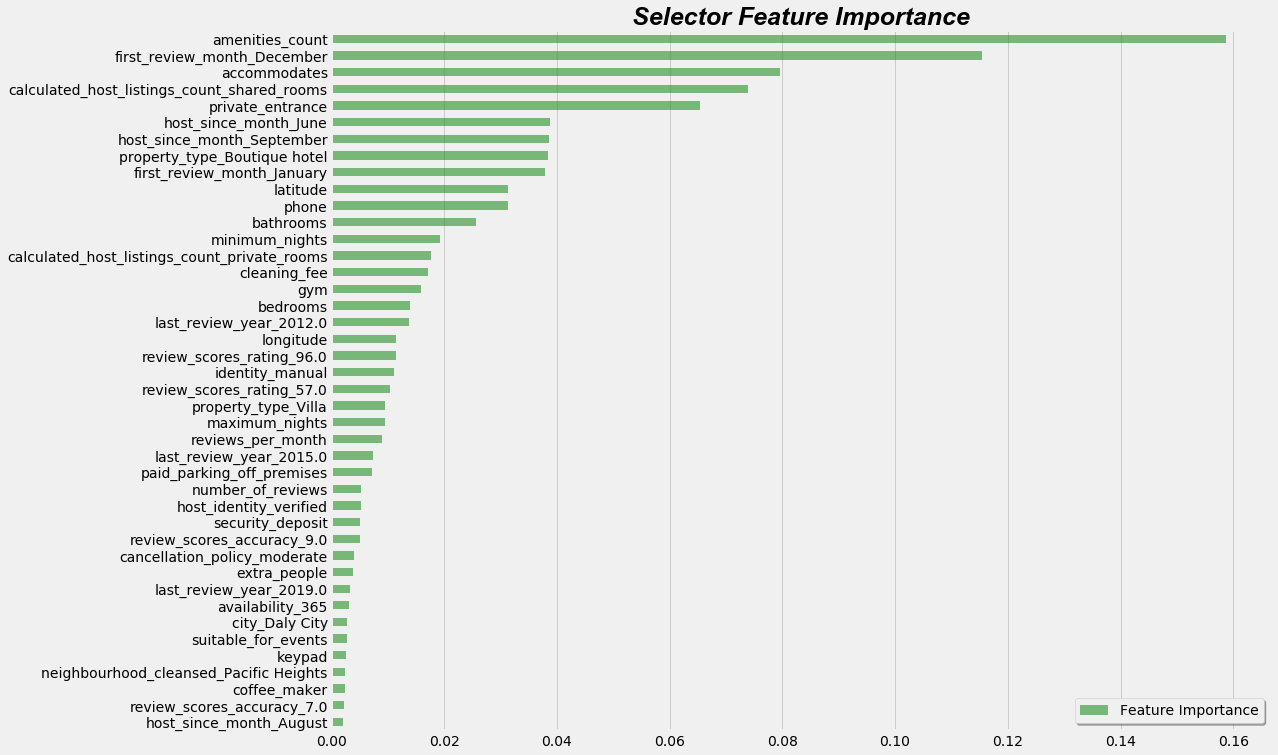

In [11]:
#Set figure
f, ax = plt.subplots(figsize = (15,12))

#Plot data
selector_feat_importance.plot(kind = 'barh', ax = ax, color = 'green', alpha = .5)

###Set Plot Aesthetics###
#Title
ax.set_title('Selector Feature Importance', fontsize = 25, fontweight = 'semibold', style = 'italic', fontname="Arial")

#Axes
ax.invert_yaxis()

#Gridlines
ax.grid(b = False, which = 'major', axis = 'y')

#Legend
ax.legend(['Feature Importance'],frameon = True, shadow = True);

**Transform Data**

We will later store this transformation into a final pipeline for deploying on test data.

In [12]:
#Transform training data
X_train_transformed = selector.transform(X_train)

#Preview
print('Transformed Training Data Shape:', X_train_transformed.shape)

Transformed Training Data Shape: (79783, 42)


## Machine Learning

### Base model pipeline development

**Objective: Select best base model to optimize and deploy on test data**

*Models to try:*
- Ensemble methods
- XGBoost

**Read in libraries**

In [13]:
#Import Pipeline
from sklearn.pipeline import Pipeline

#Import ensemble methods 
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor, AdaBoostRegressor,ExtraTreesRegressor

#Import XGB
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

**Initialize pipeline components**

Will create a list of regression models w/ a corresponding list of parameters to be fit into a pipeline. Parameters will be brief and we'll later optimize the best performing model. 

In [27]:
#Create a list of model names to be used in a print funtion later when aggregating model evaluation metrics
model_names = [
    'RandomForestRegressor',
    'GradientBoostingRegressor',
    'AdaBoostRegressor',
    'ExtraTreesRegressor',
    'XGBRegressor',
]

#Init models into a list to loop over in pipeline to evaluate all base model performances
regressors = [
    RandomForestRegressor(random_state = 42,n_estimators=200, n_jobs=-1),
    GradientBoostingRegressor(random_state = 42,n_estimators=200),
    AdaBoostRegressor(random_state = 42,n_estimators=200),
    ExtraTreesRegressor(random_state = 42,n_estimators=200, n_jobs=-1),
    XGBRegressor(random_state = 42, n_estimators = 200, n_jobs=-1)
]

**Build preliminary pipeline, evaluate results, and select model for futher development**

In [28]:
#Implement pipe for all regressors 
for name,regressor in zip(model_names, regressors):
    pipe = Pipeline([('regressor', regressor)], verbose=True)
    predictions = cross_val_predict(pipe, X_train_transformed, y_train, n_jobs=-1)
    regression_metrics(name, X_train_transformed, predictions, y_train)

Without much tuning, our best models for this data set were RandomForestRegressor, XGBRegressor, and the ExtraTreesRegressor.

We'll create an additional pipeline searching over some additional parameters using RandomSearchCV to reduce RMSE before finally selecting a final model to tune and deploy.

### Improve performance of RandomForestRegressor, XGBRegressor, and the ExtraTreesRegressor.

In [29]:
#Init libraries
from sklearn.model_selection import RandomizedSearchCV

#Set list with evaluation metrics for RandomizedSearchCV
scoring = ['r2','neg_mean_absolute_error','neg_mean_squared_error']

#Create list of model names for later loop
model_names = [
    'RandomForestRegressor',
     'ExtraTreesRegressor',
     'XGBRegressor',
]

#Init models 
regressors = [
    RandomForestRegressor(random_state = 42, n_jobs=-1),
     ExtraTreesRegressor(random_state = 42, n_jobs=-1),
     XGBRegressor(random_state = 42, n_jobs=-1)
]

#Init parameters for RandomSearchCV evaluation to search over
parameters = [
    {'model__n_estimators':[200, 300, 400],
    'model__max_depth':[10, 15, 20],
    'model__max_features': ['auto', 'sqrt', 'log2']},
     {'model__n_estimators':[200,300,400],
     'model__max_depth':[10,15,20],
     'model__max_features': ['auto', 'sqrt', 'log2']},
     {'model__n_estimators':[200,300,400],
     'model__max_depth':[10,15,20],
     'model__learning_rate': [.01,.1, 1]}
]

In [30]:
#Create pipeline with parameter grid to search over base models(randomsearch cv)
for name, regressor, parameter in zip(model_names, regressors, parameters):
    pipe = Pipeline([('model',regressor)])
    reg = RandomizedSearchCV(pipe, param_distributions=parameter, n_jobs=-1, scoring=scoring, refit='neg_mean_squared_error')
    reg.fit(X_train_transformed, y_train)
    print("{} Random Search Results:".format(name))
    print('RMSE:',np.mean(np.sqrt(-1 * (reg.cv_results_['mean_test_neg_mean_squared_error']))))
    print('MAE:',np.mean(-1 * reg.cv_results_['mean_test_neg_mean_absolute_error']))
    print('R2:',np.mean(reg.cv_results_['mean_test_r2']))
    print("\n The best estimator across ALL searched params:\n", reg.best_estimator_)
    print("\n The best parameters across searched parameters:\n", reg.best_params_)
    print("========================================================")

RandomForestRegressor Random Search Results:
RMSE: 141.41297624959526
MAE: 50.24032762061741
R2: 0.8577770404791465

 The best estimator across ALL searched params:
 Pipeline(memory=None,
         steps=[('model',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=20,
                                       max_features='sqrt', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=400, n_jobs=-1,
                                       oob_score=False, random_state=42,
                                       verbose=0, warm_start=False))],
         verbose=

### Tune Final model

We'll be further finetuning our XBRegressor model to try and further reduce RMSE

In [31]:
#Init parameters for RandomSearchCV evaluation to search over
parameters = [
    {'model__n_estimators':[400, 600, 800],
    'model__max_depth':[7,10, 13],
    'model__learning_rate': [.001,.01,.1]}
]

In [32]:
#Create pipeline with parameter grid to search over XGBRegressor 

pipe = Pipeline([('model',XGBRegressor(random_state = 42, n_jobs = -1))])
rand_xbr = RandomizedSearchCV(pipe, param_distributions=parameters, n_jobs=-1, scoring=scoring, refit='neg_mean_squared_error')
rand_xbr.fit(X_train_transformed, y_train)
print("XGBRegressor Random Search Results:")
print('RMSE:',np.mean(np.sqrt(-1 * (rand_xbr.cv_results_['mean_test_neg_mean_squared_error']))))
print('MAE:',np.mean(-1 * rand_xbr.cv_results_['mean_test_neg_mean_absolute_error']))
print('R2:',np.mean(rand_xbr.cv_results_['mean_test_r2']))
print("\n The best estimator across ALL searched params:\n", rand_xbr.best_estimator_)
print("\n The best parameters across searched parameters:\n", rand_xbr.best_params_)

XGBRegressor Random Search Results:
RMSE: 99.42071649726257
MAE: 29.999141127905336
R2: 0.9329386965899586

 The best estimator across ALL searched params:
 Pipeline(memory=None,
         steps=[('model',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, gamma=0, gpu_id=-1,
                              importance_type='gain',
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=10,
                              min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=800,
                              n_jobs=-1, num_parallel_tree=1,
                              objective='reg:squarederror', random_state=42,
                              reg_alpha=0, reg_lambda=1, scale_pos_weight=1,
                              subsample=1, 

### Build Final Pipeline

In [41]:
#Import GridSearchCV
from sklearn.model_selection import GridSearchCV

#Set final params of XGBRegressor
final_params=  {'model__n_estimators': [800], 
                'model__max_depth': [10], 
                'model__learning_rate': [0.1]}

#Init selector
selector = SelectFromModel(estimator=DecisionTreeRegressor(masklearnepth=10, random_state=42), 
                                threshold='1.25 * mean')

#Build final pipeline
final_pipe = Pipeline([('selector', selector),
                      ('model', XGBRegressor(random_state = 42, n_jobs = -1))])

#Init GridSearchCV and fit to training data
grid = GridSearchCV(final_pipe, final_params, cv =5, n_jobs=-1)
grid.fit(X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('selector',
                                        SelectFromModel(estimator=DecisionTreeRegressor(ccp_alpha=0.0,
                                                                                        criterion='mse',
                                                                                        max_depth=10,
                                                                                        max_features=None,
                                                                                        max_leaf_nodes=None,
                                                                                        min_impurity_decrease=0.0,
                                                                                        min_impurity_split=None,
                                                                                        min_samples_leaf=1,
     

**Final XGBRegressor Feature Importance**

In [56]:
#Get feature importance from final XGBRegressor Model
grid_feat_importance = pd.DataFrame(grid.best_estimator_.named_steps['model'].feature_importances_, index=X_train.columns[grid.best_estimator_.named_steps['selector'].get_support()])
grid_feat_importance.columns = ['feature_importance']
grid_feat_importance.sort_values(by='feature_importance', inplace = True)

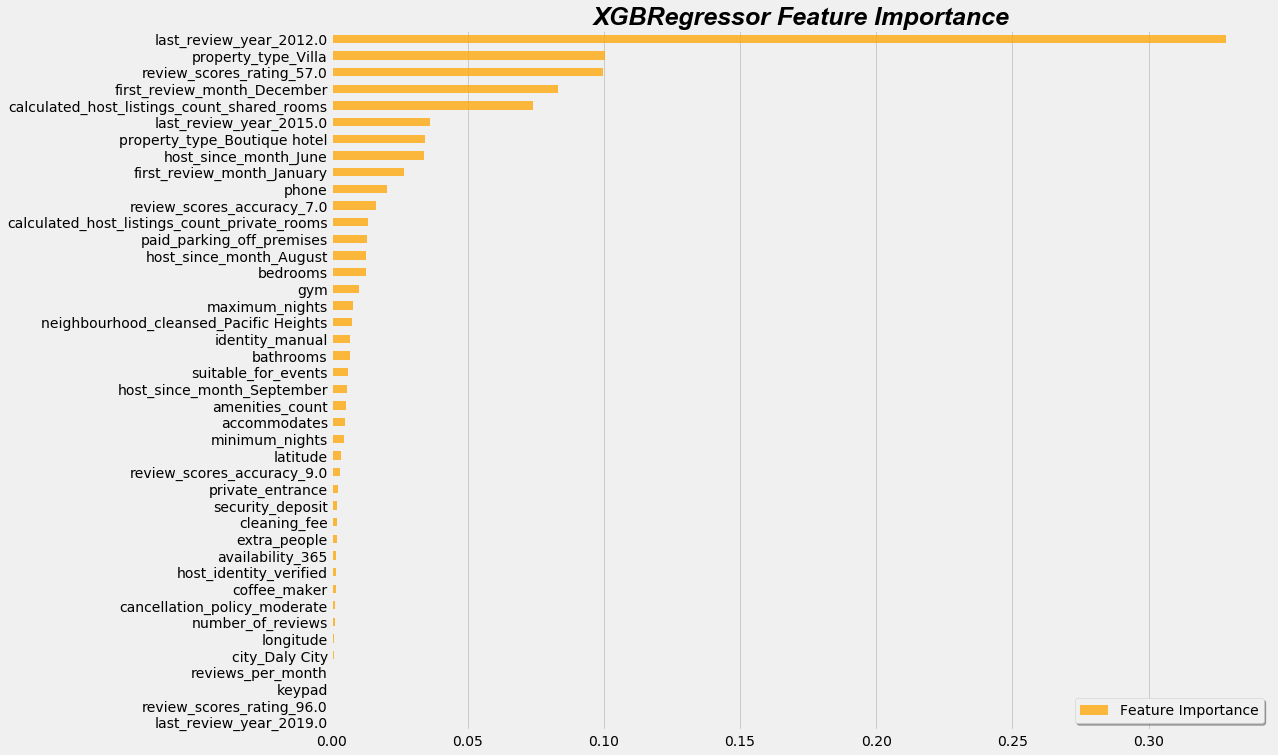

In [66]:
#Set figure
f, ax = plt.subplots(figsize = (15,12))

#Plot data
grid_feat_importance.plot(kind = 'barh', ax=ax, color = 'orange', alpha = .75)

###Set Plot Aesthetics###
#Title
ax.set_title('XGBRegressor Feature Importance', fontsize = 25, fontweight = 'semibold', style = 'italic', fontname="Arial")

#Gridlines
ax.grid(b = False, which = 'major', axis = 'y')

#Legend
ax.legend(['Feature Importance'],frameon = True, shadow = True, loc = 'lower right');

In [ ]:
#Set path for test data and tunes pipeline
path_test = r'C:\Users\kishe\Documents\Data Science\Projects\Python\In Progress\Airbnb - San Francisco\Data\04_Test_Data'
path_pipe = r'C:\Users\kishe\Documents\Data Science\Projects\Python\In Progress\Airbnb - San Francisco\Project_Codes\05_Evaluation'

#Write pipeline
from sklearn.externals import joblib
joblib.dump(grid.best_estimator_, path_pipe + 'xgbr_regressor.pkl', compress = 1)

#Write test data
X_test.to_csv(path_test + '2020_0614_Listings_Test_Data.csv')